In [1]:
# Standard library imports
import os
import re
import pickle
import random

# Data handling and numerical processing
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt

# Custom utilities and feature processing
import utils

/opt/miniconda3/envs/FeatureAggregation/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


#### Comparing three aggregation methods: profiles created with all cells, all cells except the smallest/crowded ones, and just the largest/well separated ones. 

In [2]:
# Define output dir
output_dir = Path.cwd().parents[0] / "FinalModelResults"

In [3]:
DOSE_POINT = 10

metadata_dir = os.path.join(Path.cwd().parents[0], 'aws_scripts', 'metadata', 'platemaps', '2016_04_01_a549_48hr_batch1')
platenames = ["SQ00015219", "SQ00014816", 'SQ00015117', 'SQ00015057', 'SQ00015056']

barcode_platemap = pd.read_csv(os.path.join(metadata_dir, 'barcode_platemap.csv'), index_col=False)
barcode_platemap = barcode_platemap[barcode_platemap['Assay_Plate_Barcode'].isin(platenames)]
barcode_platemap

,Assay_Plate_Barcode,Plate_Map_Name,Batch_Number,Batch_Date
45,SQ00015117,C-7161-01-LM6-001,2,2016-04-05
78,SQ00015219,C-7161-01-LM6-011,3,2016-04-26
99,SQ00015057,C-7161-01-LM6-028,4,2016-05-17
100,SQ00015056,C-7161-01-LM6-028,4,2016-05-17
108,SQ00014816,C-7161-01-LM6-023,4,2016-05-17


In [4]:
repurposing_info = pd.read_csv(os.path.join(metadata_dir, 'repurposing_info_long.tsv'), index_col=False,
                               low_memory=False, sep='\t', usecols=["broad_id", "pert_iname", "moa"])
repurposing_info = repurposing_info.rename(columns={"broad_id": "broad_sample"})
repurposing_info = repurposing_info.drop_duplicates()
repurposing_info

,broad_sample,pert_iname,moa
0,BRD-K76022557-003-28-9,(R)-(-)-apomorphine,dopamine receptor agonist
16,BRD-K76022557-003-02-7,(R)-(-)-apomorphine,dopamine receptor agonist
32,BRD-K76022557-003-29-9,(R)-(-)-apomorphine,dopamine receptor agonist
48,BRD-K76022557-001-03-9,(R)-(-)-apomorphine,dopamine receptor agonist
64,BRD-K75516118-001-04-1,(R)-(-)-rolipram,phosphodiesterase inhibitor
...,...,...,...
39464,BRD-K00535541-001-06-3,9-aminoacridine,NaN
39465,BRD-K09291936-001-13-3,9-aminocamptothecin,topoisomerase inhibitor
39466,BRD-K09291936-001-14-9,9-aminocamptothecin,topoisomerase inhibitor
39467,BRD-K62607075-001-04-9,9-anthracenecarboxylic-acid,NaN


In [5]:
bigdf = []
for i, platestring in enumerate(platenames):
    # print('Getting data from: ' + platestring)
    platemap_name = barcode_platemap[barcode_platemap["Assay_Plate_Barcode"] == platestring]["Plate_Map_Name"].iloc[0]
    print(platemap_name)
    C_metadata = pd.read_csv(os.path.join(metadata_dir, 'platemap', platemap_name +'.txt'), sep='\t')
    if DOSE_POINT == 10:
        df = C_metadata[np.logical_and(C_metadata['mmoles_per_liter'] > 9, C_metadata['mmoles_per_liter'] < 11)]
    elif DOSE_POINT == 3:
        df = C_metadata[np.logical_and(C_metadata['mmoles_per_liter'] > 2.9, C_metadata['mmoles_per_liter'] < 6)]

    df['plate'] = platestring
    bigdf.append(df)

bigdf = pd.merge(pd.concat(bigdf), repurposing_info, on='broad_sample', how='left')
bigdf = utils.filterData(bigdf, 'negcon', encode='pert_iname', mode='LINCS')
shape1 = bigdf.shape[0]
bigdf.dropna(inplace=True)  # drop all compounds without annotations for pert_iname (and moa)
shape2 = bigdf.shape[0]
print("Removed", shape1-shape2, "wells due to missing annotation of pert_iname and moa.")
bigdf = bigdf[bigdf.Metadata_labels.duplicated(keep=False)]
print("Resulting df shape:", bigdf.shape)

C-7161-01-LM6-011
C-7161-01-LM6-023
C-7161-01-LM6-001
C-7161-01-LM6-028
C-7161-01-LM6-028
Removed 75 wells due to missing annotation of pert_iname and moa.
Resulting df shape: (74, 10)


/var/folders/0n/sy07p4_n4jzgg1n5phyn9yq00000gn/T/ipykernel_16066/3197329248.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plate'] = platestring
/var/folders/0n/sy07p4_n4jzgg1n5phyn9yq00000gn/T/ipykernel_16066/3197329248.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plate'] = platestring
/var/folders/0n/sy07p4_n4jzgg1n5phyn9yq00000gn/T/ipykernel_16066/3197329248.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [6]:
directory = os.path.join(Path.cwd().parents[0], "datasets", "LINCS")
map_label = "Metadata_broad_sample"
fois = ["Cells_AreaShape_MeanRadius", "Cells_AreaShape_MaximumRadius", "Cells_AreaShape_MedianRadius", "Cells_AreaShape_Area"]

def find_pickle_files(directory):
    pickle_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".pkl"):
                pickle_files.append(os.path.join(root, file))
    return pickle_files


ap_list_inclusion = []
r = range(1, 100)
for lowerbound in r:
    lowerbound *= 0.01
    average_profiles = pd.DataFrame()
    for pickle_file in find_pickle_files(directory):
        match = re.search(r'DataLoader_(\w+)', pickle_file)
        platename = match.group(1)
        
        with open(pickle_file, "rb") as f:
            data = pickle.load(f)
        if not "broad_sample" in data:
            continue
            
        points = data["cell_features"]
        label = data["broad_sample"]
        lower_quantiles = {foi: np.quantile(points[foi].values, lowerbound) for foi in fois}

        mask = np.ones(len(points), dtype=bool)
        for foi in fois:
            mask &= (points[foi] < lower_quantiles[foi])
        
        filtered_points = points[mask]
        temp = pd.concat([pd.Series({map_label: label}), pd.Series({"Metadata_plate": platename}), pd.DataFrame(filtered_points.mean())]).T
        average_profiles = pd.concat([average_profiles, temp])
    
    # Preprocess further
    average_profiles.dropna(inplace=True)
    
    label_counts = average_profiles[map_label].value_counts()
    labels_to_keep = label_counts[label_counts >= 2].index
    
    average_profiles = average_profiles[average_profiles[map_label].isin(labels_to_keep)]
    
    # Compute AP
    ap = utils.CalculateMAP(average_profiles, 'cosine_similarity', groupby=map_label, percent_matching=False)
    ap_list_inclusion.append(ap.AP.mean())


/Users/rdijk/Desktop/Revision/FULL_BACKUP/2024_vanDijk_PLoS_CytoSummaryNet/AllPaperFigures/utils.py:335: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=1, inplace=True)
/Users/rdijk/Desktop/Revision/FULL_BACKUP/2024_vanDijk_PLoS_CytoSummaryNet/AllPaperFigures/utils.py:336: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=0, inplace=True)
/Users/rdijk/Desktop/Revision/FULL_BACKUP/2024_vanDijk_PLoS_CytoSummaryNet/AllPaperFigures/utils.py:335: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=1, inplace=True)
/Users/rdijk/Desktop/Revision/FULL_BACKUP/2024_vanDi

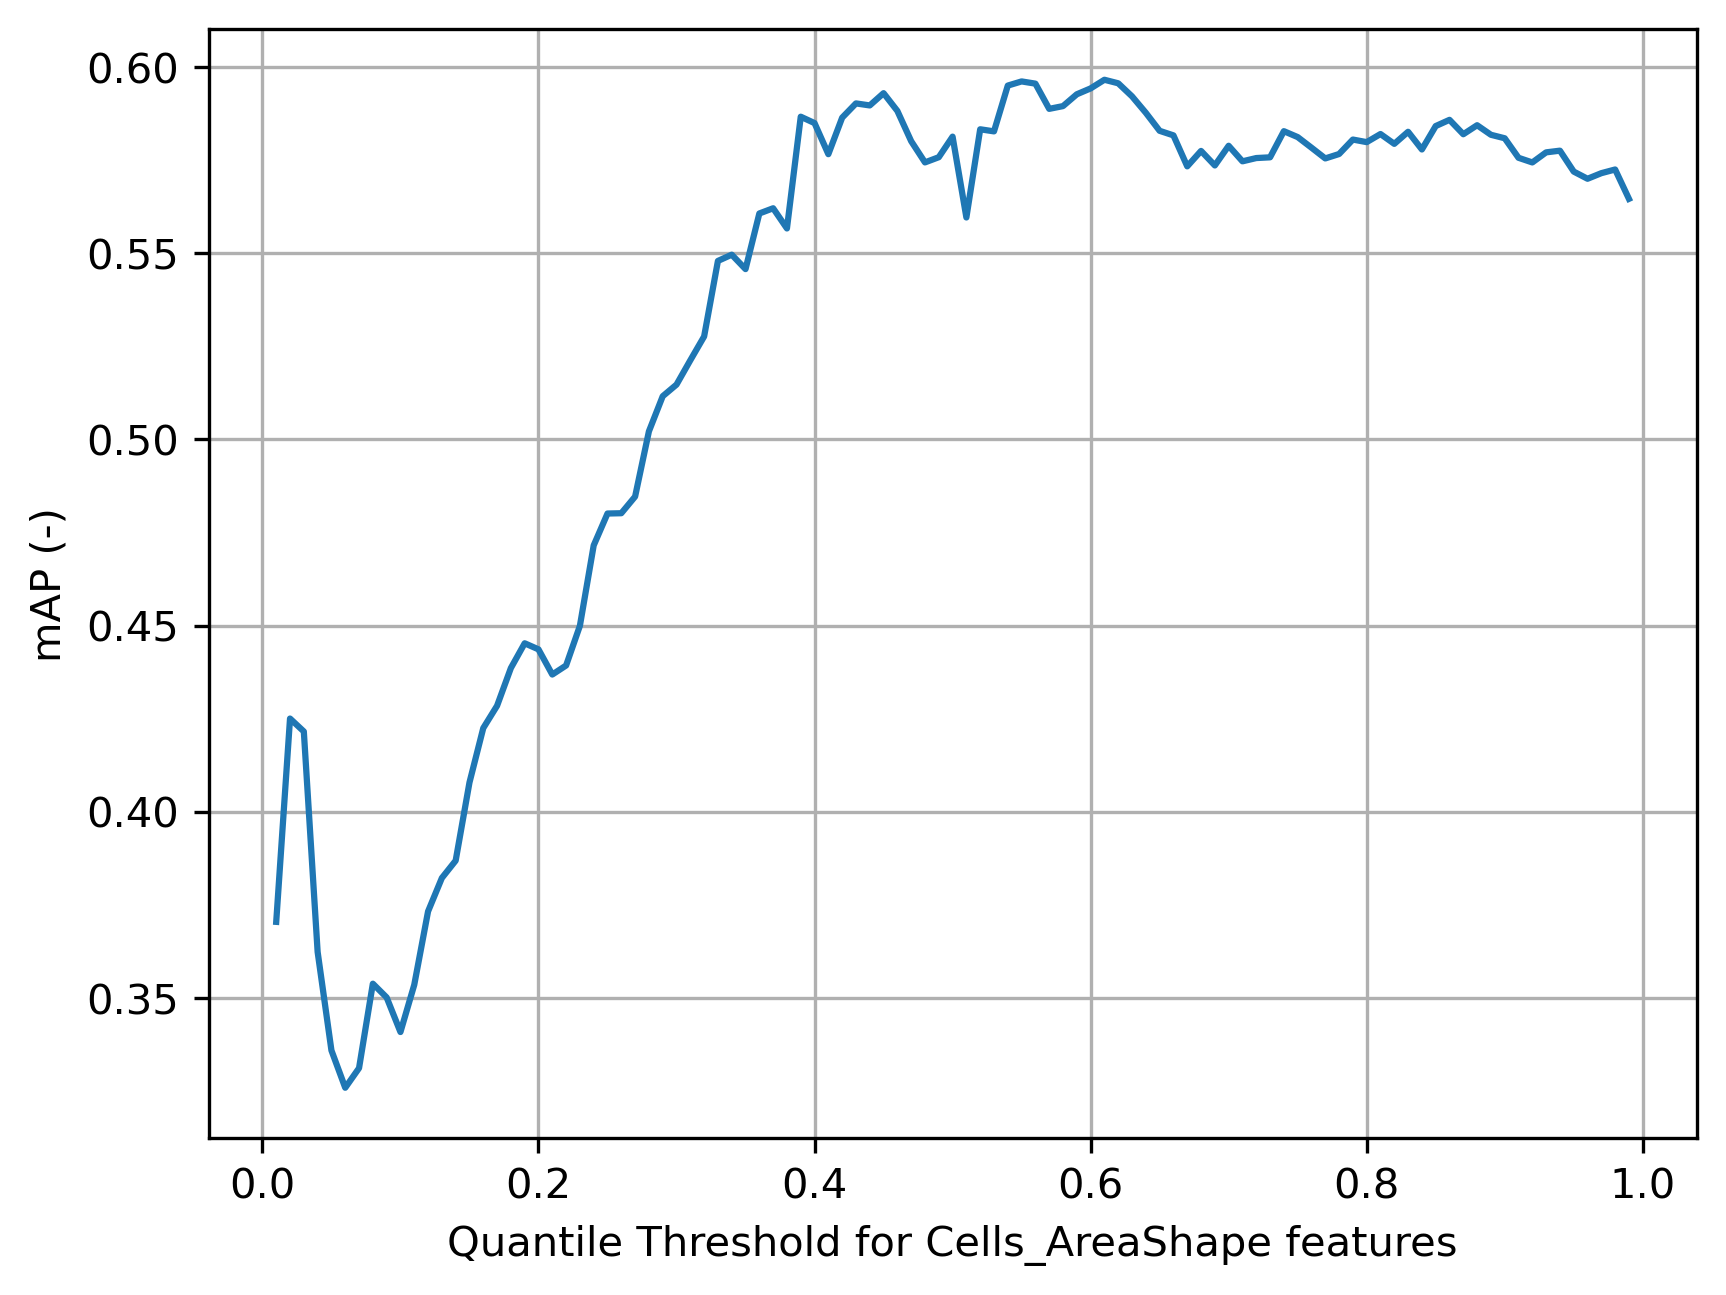

In [7]:
thresholds = (np.array(r)*0.01).tolist()
plt.figure(dpi=300)
plt.plot(thresholds, ap_list_inclusion)
plt.xlabel('Quantile Threshold for Cells_AreaShape features')
plt.ylabel('mAP (-)')
plt.grid(True)
plt.savefig(os.path.join("Figures", "S1FigK_InterpretabilityInclusion.png"))
plt.show()

In [8]:
ap_list_exclusion = []
r = range(1, 100)
for lowerbound in r:
    lowerbound *= 0.01
    average_profiles = pd.DataFrame()
    for pickle_file in find_pickle_files(directory):
        match = re.search(r'DataLoader_(\w+)', pickle_file)
        platename = match.group(1)
        
        with open(pickle_file, "rb") as f:
            data = pickle.load(f)
        if not "broad_sample" in data:
            continue
            
        points = data["cell_features"]
        label = data["broad_sample"]
        lower_quantiles = {foi: np.quantile(points[foi].values, lowerbound) for foi in fois}

        mask = np.ones(len(points), dtype=bool)
        for foi in fois:
            mask &= (points[foi] > lower_quantiles[foi])
        
        filtered_points = points[mask]
        temp = pd.concat([pd.Series({map_label: label}), pd.Series({"Metadata_plate": platename}), pd.DataFrame(filtered_points.mean())]).T
        average_profiles = pd.concat([average_profiles, temp])
    
    # Preprocess further
    average_profiles.dropna(inplace=True)
    
    label_counts = average_profiles[map_label].value_counts()
    labels_to_keep = label_counts[label_counts >= 2].index
    
    average_profiles = average_profiles[average_profiles[map_label].isin(labels_to_keep)]
    
    # Compute AP
    ap = utils.CalculateMAP(average_profiles, 'cosine_similarity', groupby=map_label, percent_matching=False)
    ap_list_exclusion.append(ap.AP.mean())


/Users/rdijk/Desktop/Revision/FULL_BACKUP/2024_vanDijk_PLoS_CytoSummaryNet/AllPaperFigures/utils.py:335: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=1, inplace=True)
/Users/rdijk/Desktop/Revision/FULL_BACKUP/2024_vanDijk_PLoS_CytoSummaryNet/AllPaperFigures/utils.py:336: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=0, inplace=True)
/Users/rdijk/Desktop/Revision/FULL_BACKUP/2024_vanDijk_PLoS_CytoSummaryNet/AllPaperFigures/utils.py:335: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=1, inplace=True)
/Users/rdijk/Desktop/Revision/FULL_BACKUP/2024_vanDi

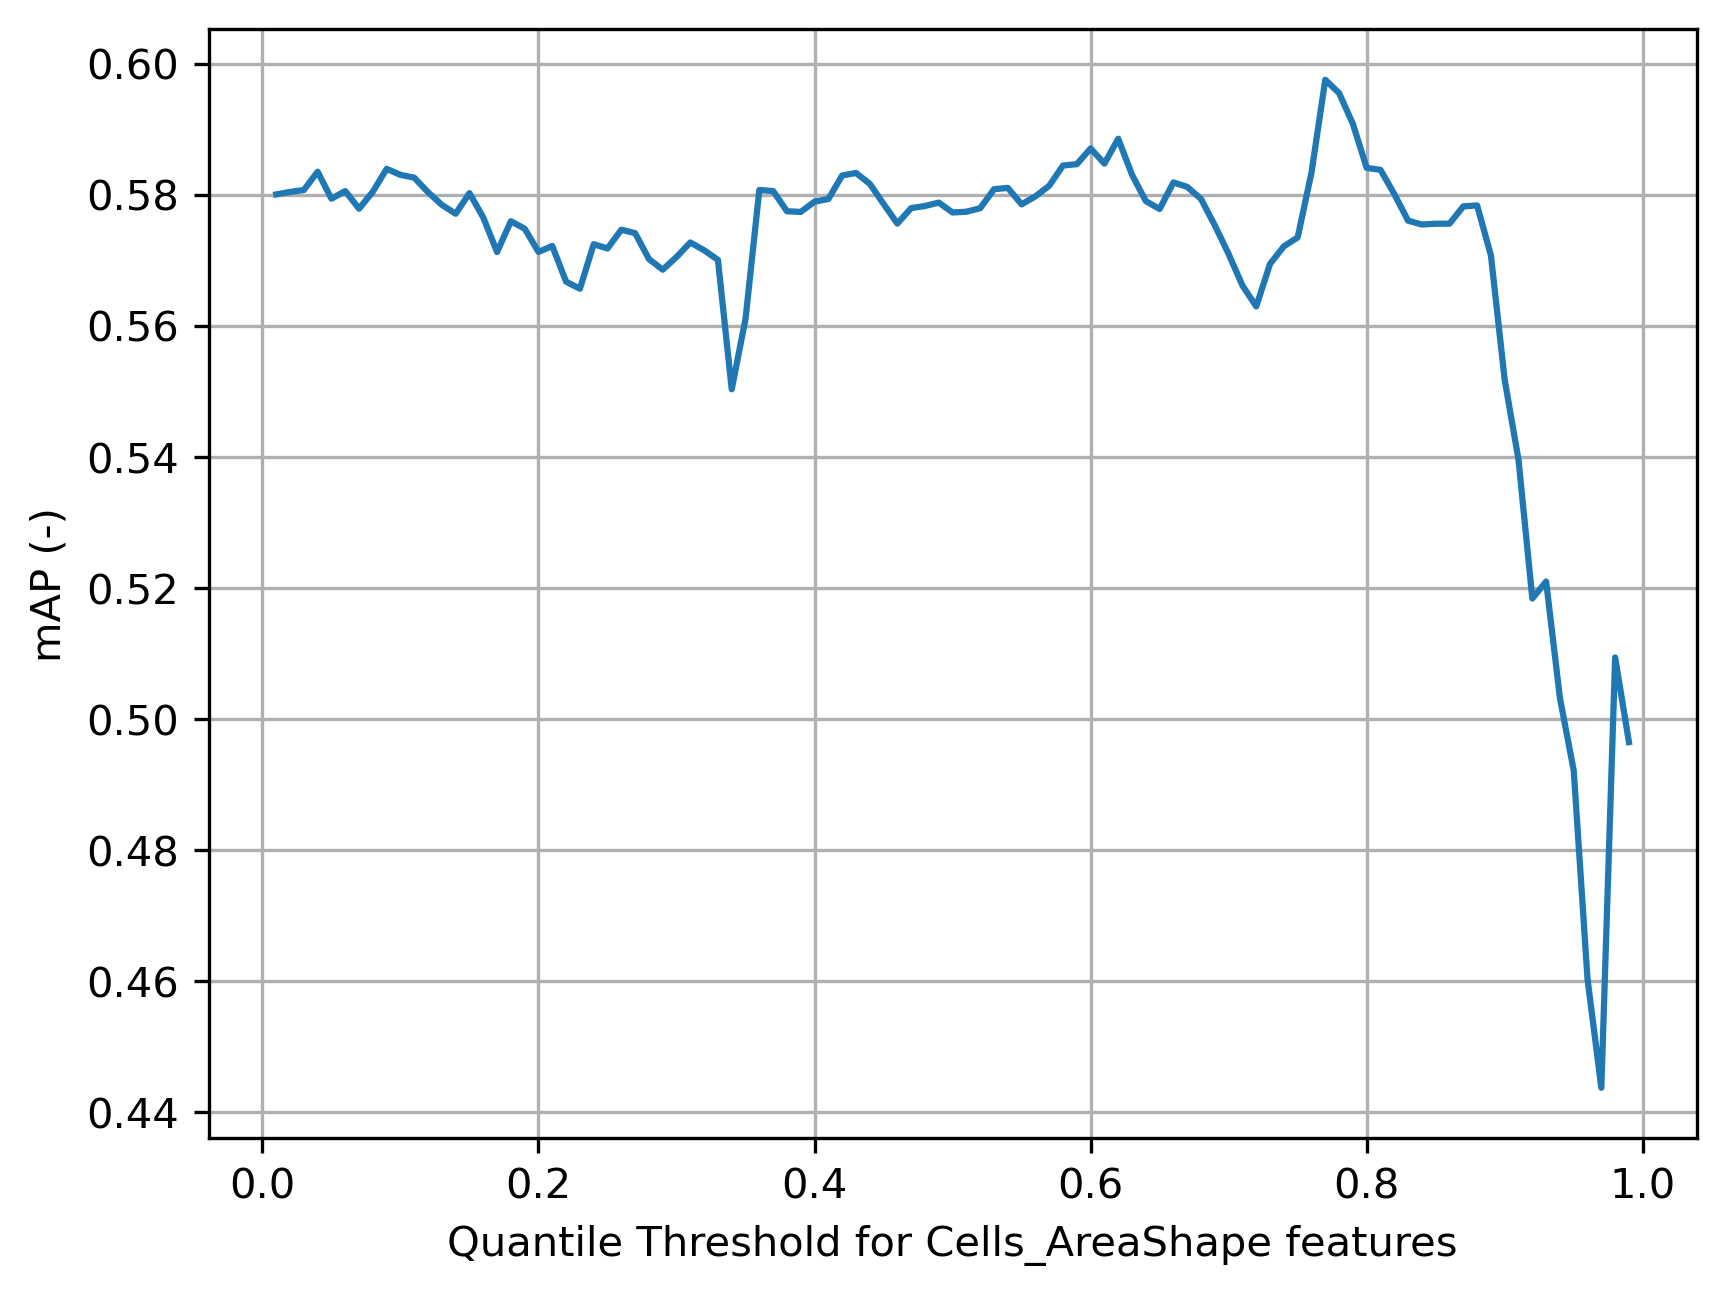

In [9]:
thresholds = (np.array(r)*0.01).tolist()
plt.figure(dpi=300)
plt.plot(thresholds, ap_list_exclusion)
plt.xlabel('Quantile Threshold for Cells_AreaShape features')
plt.ylabel('mAP (-)')
plt.grid(True)
plt.savefig(os.path.join("Figures", "S1FigK_InterpretabilityExclusion.png"))
plt.show()